In [121]:
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
import os
from helpers import *
from preprocessing import *
import pickle
from neural_network_model import NeuralNetwork

In [122]:
#x_train, x_test, y_train, train_ids, test_ids=load_csv_data("data")

In [123]:
DATA_FOLDER = 'data/'

In [124]:
try:
    with open(DATA_FOLDER + 'x_train.pickle', 'rb') as f:
        x_train = pickle.load(f)
    with open(DATA_FOLDER + 'x_test.pickle', 'rb') as f:
        x_test = pickle.load(f)
    with open(DATA_FOLDER + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(DATA_FOLDER + 'test_ids.pickle', 'rb') as f:
        test_ids = pickle.load(f)
    with open(DATA_FOLDER + 'names_map.pickle', 'rb') as f:
        names_map = pickle.load(f)
except:
    x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATA_FOLDER, sub_sample=False)

    names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
    names = np.delete(names, 0)
    names_map = {}
    for i in range(len(names)):
        names_map[names[i]] = i

    with open(DATA_FOLDER + 'x_train.pickle', 'wb') as f:
        pickle.dump(x_train, f)

    with open(DATA_FOLDER + 'x_test.pickle', 'wb') as f:
        pickle.dump(x_test, f)

    with open(DATA_FOLDER + 'y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f)

    with open(DATA_FOLDER + 'test_ids.pickle', 'wb') as f:
        pickle.dump(test_ids, f)
    
    with open(DATA_FOLDER + 'names_map.pickle', 'wb') as f:
        pickle.dump(names_map, f)

## Preprocessing and Scalings

In [125]:
DATA_FOLDER = 'data/'

In [126]:
names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
names = np.delete(names, 0)
names_map = {}
for i in range(len(names)):
    names_map[names[i]] = i

In [127]:
y_train = np.where(y_train == -1, 0, y_train)
x_tr = x_train.copy()
y_tr = y_train.copy()


In [128]:
x_tr, x_val, y_tr, y_val = split_data(x_tr, y_tr, 0.8, seed=1)

In [129]:
#clean the data and return the cleaned dataset, the y values, the mean and median dictionaries to use to clean other sets (test set for example)
x_tr_clean, y_tr_clean, mean_dico, median_dico, interesting_features = clean_data(names_map, x_tr, y_tr, is_y=True, is_train_data=True)
x_val_clean, y_val_clean, _, _, _ = clean_data(names_map, x_val, y_val, is_y=True, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

#if we don't have the y values, we use is_y=False.
x_test_clean, _, _, _, _ = clean_data(names_map, x_test, y_raw=None, is_y=False, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

In [130]:
np.where(y_tr_clean==1)[0].shape[0]/y_tr_clean.shape[0]

0.08880491261218705

In [131]:
np.where(y_val_clean==1)[0].shape[0]/y_val_clean.shape[0]

0.08629070352141649

## Feature selection

We chose some initial features by reading the report and assessing how they seemed relevant for our predictions.

In [132]:
interesting_features_indexes=np.array([names_map[feature] for feature in interesting_features])

In [133]:
X_train=x_tr_clean[:,interesting_features_indexes].copy()
X_validation = x_val_clean[:,interesting_features_indexes].copy()
X_test=x_test_clean[:,interesting_features_indexes].copy()

### Build polynomial expansion

In [134]:
max_degree=3

# without interactions since it makes matrices too large
interactions=False

X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=max_degree,interactions=interactions)
X_val_poly,_=build_poly_expansion_with_interaction_features(X_validation,features_names=interesting_features,max_degree=max_degree,interactions=interactions)
X_test_poly,_=build_poly_expansion_with_interaction_features(X_test,features_names=interesting_features,max_degree=max_degree,interactions=interactions)

### Scale data

In [135]:
X_train_poly, train_mean_poly, train_std_poly=scale_data(X_train_poly,is_train_data=True)
X_val_poly, _, _=scale_data(X_val_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)
X_test_poly,_,_=scale_data(X_test_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)

### Selecting features by correlation with the outcome y

In [136]:
correlations = np.corrcoef(np.hstack([X_train_poly, y_tr_clean.reshape(-1,1)]), rowvar=False)[:, X_train_poly.shape[1]][:-1]

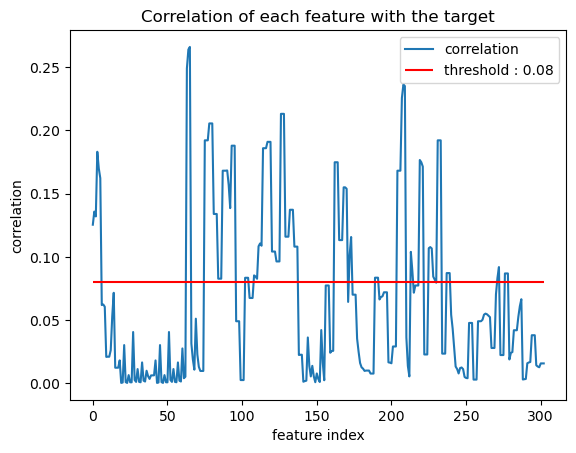

In [137]:
threshold = 0.08
plt.plot(np.abs(correlations))
plt.hlines(y=threshold, xmin=0, xmax=len(correlations) - 1, color='r')
plt.xlabel('feature index')
plt.ylabel('correlation')
plt.title('Correlation of each feature with the target')
plt.legend(['correlation', f"threshold : {threshold}"])
plt.show()

In [138]:
high_corr_indexes = np.where(correlations > threshold)[0]

In [139]:
high_corr_indexes.shape

(20,)

In [140]:
X_train_corr = X_train_poly[:, high_corr_indexes].copy()
X_val_corr = X_val_poly[:, high_corr_indexes].copy()

In [141]:
high_corr_features=list(np.array(features_names)[high_corr_indexes])
print(f"Features selected by high correlation with output (threshold)={threshold} : {len(high_corr_features)} features: \n {high_corr_features}")

Features selected by high correlation with output (threshold)=0.08 : 20 features: 
 ['POORHLTH**1', 'POORHLTH**2', 'POORHLTH**3', 'PHYSHLTH**1', 'PHYSHLTH**2', 'PHYSHLTH**3', 'GENHLTH**1', 'GENHLTH**2', 'GENHLTH**3', 'JOINPAIN**2', 'JOINPAIN**3', '_AGEG5YR**1', '_AGEG5YR**2', '_AGEG5YR**3', '_RFCHOL**1', '_RFCHOL**2', '_RFCHOL**3', 'DRNKANY5**1', 'DRNKANY5**2', 'DRNKANY5**3']


## Data augmentation

We perform data augmentation so that the model sees more positive labels. We do it by resampling positive samples. This way the model tends to predict more 1 than without and gives a better f1-score.

In [142]:
def augment_data_with_positive_samples(X, y, ratio):
    required_ones = int(0.5 * len(y))
    existing_ones_indices = np.where(y == 1)[0]
    zeros_indices = np.where(y == 0)[0]
    np.random.seed(69)
    ones_indices = np.random.choice(existing_ones_indices, required_ones - len(existing_ones_indices), replace=True)
    zeros_indices=np.random.choice(zeros_indices,len(y)-required_ones,replace=False)
    result_indices = np.concatenate([existing_ones_indices, ones_indices,zeros_indices])
    
    X_aug=X[result_indices].copy()
    y_aug=y[result_indices].copy()
    
    return X_aug, y_aug

## Ridge regression

#### With original dataset

c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:441: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


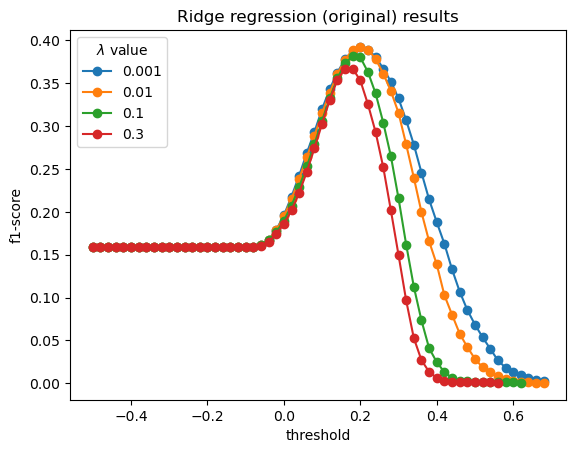

Ridge regression (original):
Best f1-score: 0.392, best lambda: 0.01, best threshold: 0.200


In [143]:
thr_l=np.arange(-0.5,0.7,0.02)
scores = []
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_validation,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (original) results")
plt.show()

print(f'Ridge regression (original):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original and augmented dataset

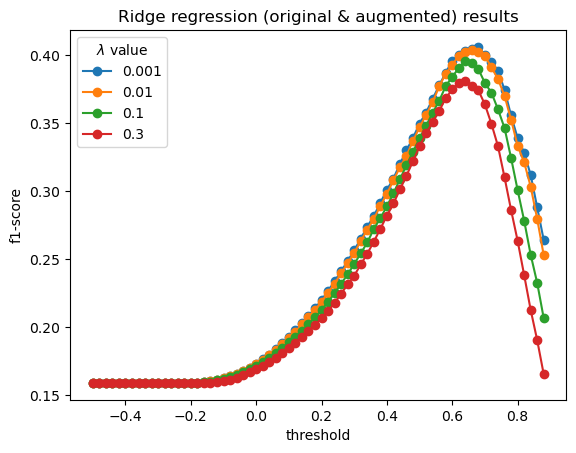

Ridge regression (original & augmented):
Best f1-score: 0.406, best lambda: 0.001, best threshold: 0.680


In [144]:
X_train_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train,y_tr_clean,ratio=0.5)

thr_l=np.arange(-0.5,0.9,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_validation,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (original & augmented) results")
plt.show()

print(f'Ridge regression (original & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original, scaled & augmented dataset

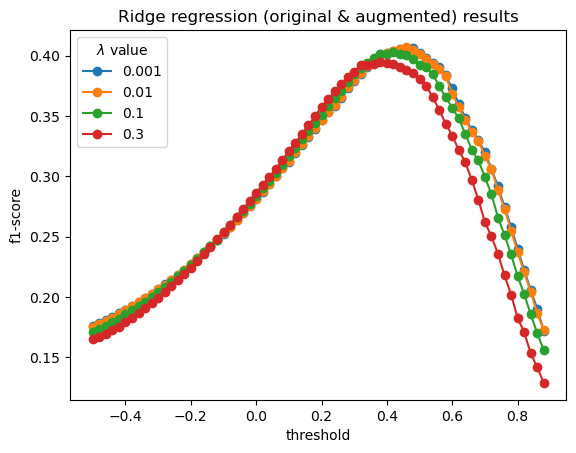

Ridge regression (original, scaled & augmented):
Best f1-score: 0.407, best lambda: 0.01, best threshold: 0.460


In [145]:
X_train_scaled, train_mean, train_std=scale_data(X_train,is_train_data=True)
X_validation_scaled, _, _=scale_data(X_validation,is_train_data=False,train_mean=train_mean,train_std=train_std)

X_train_scaled_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_scaled,y_tr_clean,ratio=0.5)

thr_l=np.arange(-0.5,0.9,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_scaled_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_validation_scaled,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (original & augmented) results")
plt.show()

print(f'Ridge regression (original, scaled & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original expanded and scaled dataset

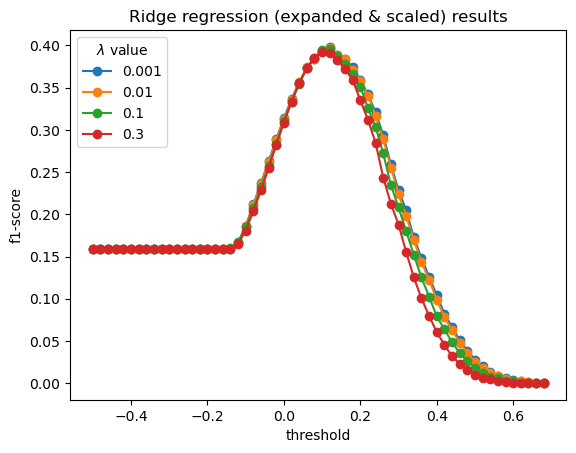

Ridge regression (expanded & scaled):
Best f1-score: 0.398, best lambda: 0.001, best threshold: 0.120


In [146]:
thr_l=np.arange(-0.5,0.7,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train_poly,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_poly,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (expanded & scaled) results")
plt.show()

print(f'Ridge regression (expanded & scaled):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original expanded, scaled and augmented dataset

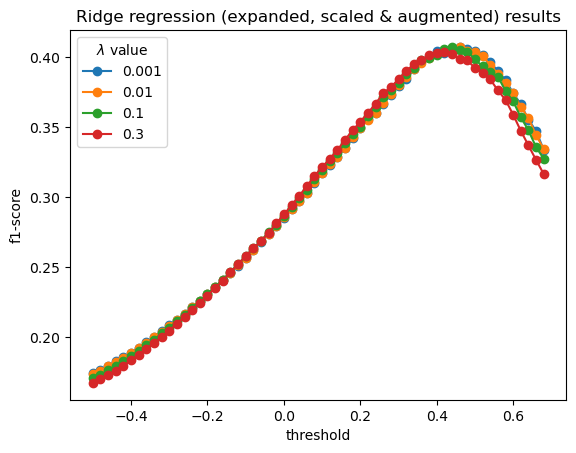

Ridge regression (expanded, scaled & augmented):
Best f1-score: 0.407, best lambda: 0.001, best threshold: 0.460


In [147]:
X_train_poly_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_poly,y_tr_clean,ratio=0.5)
best_score = 0
best_lambda = 0
best_threshold = 0

thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_poly_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_poly,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (expanded, scaled & augmented) results")
plt.show()

print(f'Ridge regression (expanded, scaled & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With dataset of correlation selection features

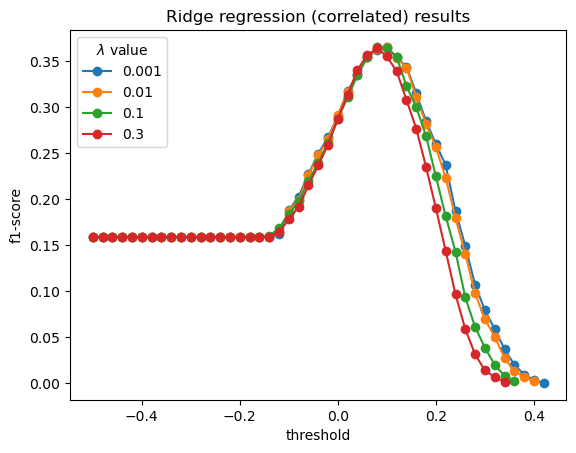

Ridge regression (correlation selection):
Best f1-score: 0.365, best lambda: 0.01, best threshold: 0.100


In [148]:
thr_l=np.arange(-0.5,0.7,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train_corr,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_corr,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (correlated) results")
plt.show()

print(f'Ridge regression (correlation selection):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With dataset of correlated features and augmented

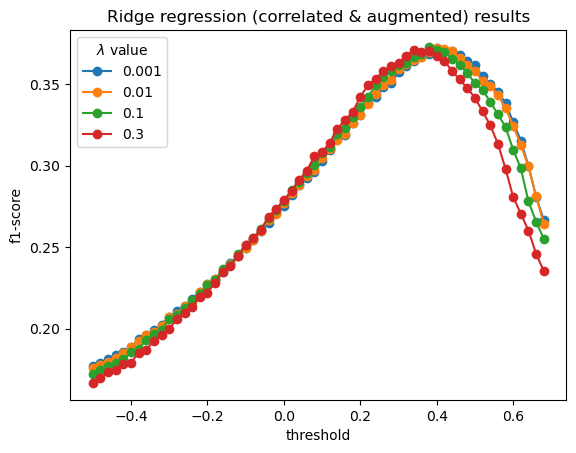

Ridge regression (correlation selection & augmented):
Best f1-score: 0.373, best lambda: 0.1, best threshold: 0.380


In [149]:
X_train_corr_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_corr,y_tr_clean,ratio=0.5)
best_score = 0
best_lambda = 0
best_threshold = 0

thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_corr_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_corr,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (correlated & augmented) results")
plt.show()

print(f'Ridge regression (correlation selection & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

## Logistic regression

#### With original expanded, scaled and augmented dataset

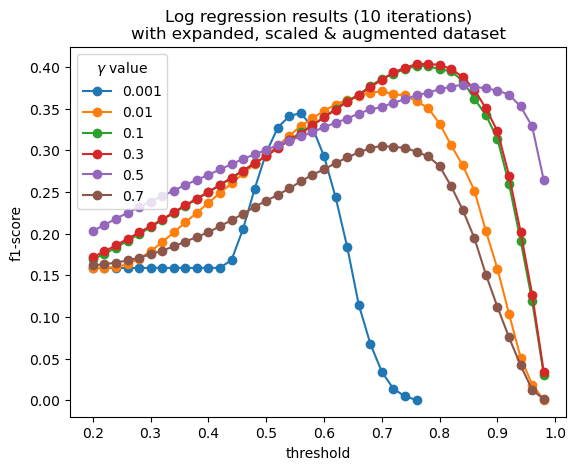

Log regression (expanded, scaled & augmented):
Best f1-score: 0.404, best gamma: 0.3, best threshold: 0.760


In [151]:
X_train_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_poly,y_tr_clean,ratio=0.5)
w_opt, loss = logistic_regression(y_train_clean_aug,X_train_aug,initial_w=np.zeros(X_train_aug.shape[1]),max_iters=10,gamma=0.01)

best_score = 0
best_threshold = 0
best_gamma = 0

thr_l=np.arange(0.2,1,0.02)
for gamma in [0.001,0.01,0.1,0.3,0.5,0.7]:
    w_opt, loss = logistic_regression(y_train_clean_aug,X_train_aug,initial_w=np.zeros(X_train_aug.shape[1]),max_iters=40,gamma=gamma)
    f1_scores=[compute_scores_logistic_regression(X_val_poly,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_gamma = gamma
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.legend(title="$\\gamma$ value", loc='upper left')
plt.title("Log regression results (40 iterations)\nwith expanded, scaled & augmented dataset")

plt.show()

print(f'Log regression (expanded, scaled & augmented):\nBest f1-score: {best_score:.3f}, best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

Regularized log regression, grid search on $\lambda$ and $\gamma$:

This step is long (more than an hour) so you should not run it if you don't need to

In [ ]:
compute_grid_search=False

c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:452: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:206: RuntimeWarning: divide by zero encountered in log
  + (1 - y[i]) * np.log(1 - sigmoid(tx[i].T @ w))
c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:206: RuntimeWarning: invalid value encountered in scalar multiply
  + (1 - y[i]) * np.log(1 - sigmoid(tx[i].T @ w))


KeyboardInterrupt: 

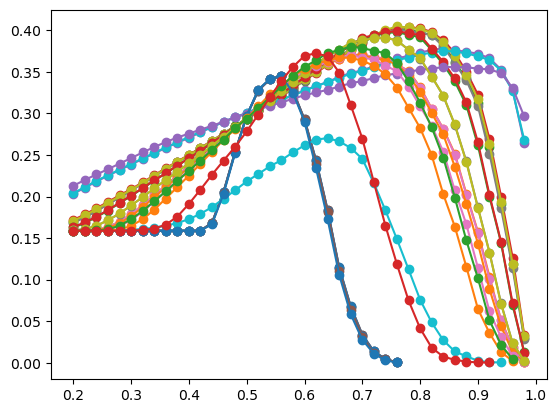

In [152]:
if compute_grid_search:
    best_score = 0
    best_threshold = 0
    best_gamma = 0
    best_lambda_=0
    thr_l=np.arange(0.2,1,0.02)
    for lambda_ in [0.001,0.01,0.1,0.3,0.7]:
        for gamma in [0.001,0.01,0.1,0.3,0.5]:
            w_opt, loss = reg_logistic_regression(y_train_clean_aug,X_train_aug,lambda_=lambda_,initial_w=np.zeros(X_train_aug.shape[1]),max_iters=40,gamma=gamma)
            f1_scores=[compute_scores_logistic_regression(X_val_poly,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
            cur_best_score = np.nanmax(f1_scores)
            if cur_best_score > best_score:
                best_score = cur_best_score
                best_gamma = gamma
                best_lambda_=lambda_
                best_threshold = thr_l[np.nanargmax(f1_scores)]
            plt.plot(thr_l,f1_scores,marker='o',label=str(gamma)+" -"+str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    plt.legend(title="$\\gamma - \\lambda$ value", loc='upper left')
    plt.title("Log regression results (40 iterations)\nwith initial features, scaled & augmented dataset")

    plt.show()

    print(f'Log regression (initial features, scaled & augmented dataset):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda_},best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

#### With dataset of correlated features and augmented

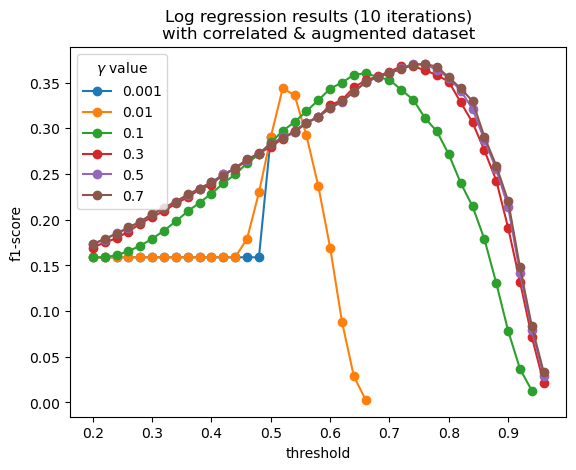

Log regression (correlated & augmented):
Best f1-score: 0.370, best gamma: 0.7, best threshold: 0.760


In [ ]:
X_train_corr_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_corr,y_tr_clean,ratio=0.5)
w_opt, loss = logistic_regression(y_train_clean_aug,X_train_corr_aug,initial_w=np.zeros(X_train_corr_aug.shape[1]),max_iters=10,gamma=0.01)

best_score = 0
best_threshold = 0
best_gamma = 0

thr_l=np.arange(0.2,1,0.02)
for gamma in [0.001,0.01,0.1,0.3,0.5,0.7]:
    w_opt, loss = logistic_regression(y_train_clean_aug,X_train_corr_aug,initial_w=np.zeros(X_train_corr_aug.shape[1]),max_iters=10,gamma=gamma)
    f1_scores=[compute_scores_logistic_regression(X_val_corr,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_gamma = gamma
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.legend(title="$\\gamma$ value", loc='upper left')
plt.title("Log regression results (10 iterations)\nwith correlation selected features & augmented dataset")
plt.show()

print(f'Log regression (correlation selection & augmented):\nBest f1-score: {best_score:.3f}, best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

### Selection by ridge regression weight

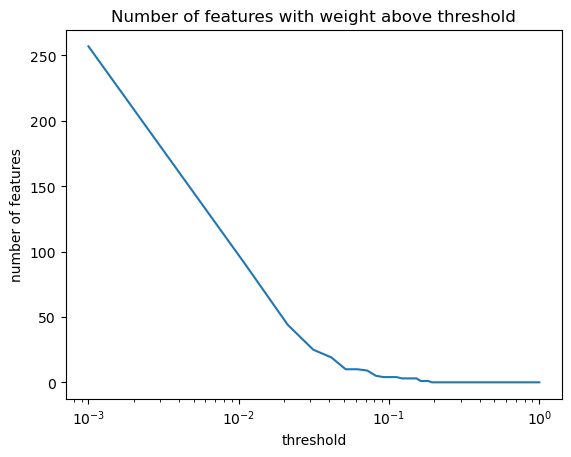

In [ ]:
X_train_poly_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_poly,y_tr_clean,ratio=0.5)

w_opt_ridge,loss = ridge_regression(y_train_clean_aug,X_train_poly_aug,lambda_=0.001)
filter_ = lambda x: np.where(np.abs(w_opt_ridge) > x)[0].shape[0]
x = np.linspace(0.001, 1, 100)
plt.plot(x, np.vectorize(filter_)(x))
plt.xscale('log')
plt.xlabel('threshold')
plt.ylabel('number of features')
plt.title('Number of features with weight above threshold')
plt.show()

np.where(np.abs(w_opt_ridge) > 0.01)[0];

In [ ]:
threshold = 0.03

high_weight_features=list(np.array(features_names)[np.where(np.abs(w_opt_ridge) > threshold)[0]])
print(f"Features selected by ridge regression weight (threshold)={threshold} : {len(high_weight_features)} features : \n {high_weight_features}")

Features selected by ridge regression weight (threshold)=0.01 : 102 features : 
 ['PHYSHLTH**1', 'PHYSHLTH**2', 'PHYSHLTH**3', 'MENTHLTH**1', 'MENTHLTH**2', 'MENTHLTH**3', 'WEIGHT2**1', 'WEIGHT2**2', 'WEIGHT2**3', 'DIABAGE2**1', 'DIABAGE2**2', 'HEIGHT3**1', 'HEIGHT3**2', 'HEIGHT3**3', 'FRUITJU1**2', 'FRUITJU1**3', 'FRUIT1**1', 'FRUIT1**2', 'FRUIT1**3', 'FVBEANS**2', 'VEGETAB1**2', 'EXERHMM1**1', 'EXERHMM1**2', 'EXERHMM1**3', 'FTJUDA1_**2', 'FTJUDA1_**3', 'FRUTDA1_**1', 'FRUTDA1_**2', 'FRUTDA1_**3', 'BEANDAY_**1', 'BEANDAY_**2', 'VEGEDA1_**2', 'GENHLTH**1', 'GENHLTH**2', 'GENHLTH**3', 'CHECKUP1**1', 'CHECKUP1**2', 'CHECKUP1**3', 'TOLDHI2**1', 'TOLDHI2**2', 'TOLDHI2**3', 'CVDSTRK3**1', 'CVDSTRK3**2', 'CVDSTRK3**3', 'DIABETE3**1', 'DIABETE3**3', 'CHCCOPD1**1', 'CHCCOPD1**2', 'CHCCOPD1**3', 'EDUCA**1', 'INCOME2**2', 'INCOME2**3', 'SMOKE100**1', 'SMOKE100**2', 'SMOKE100**3', 'USENOW3**1', 'ALCDAY5**2', 'ALCDAY5**3', 'AVEDRNK2**1', 'DRNK3GE5**1', 'DRNK3GE5**2', 'SEATBELT**1', 'PNEUVAC3**1', 

#### Differences between chosen features by correlation and by weight

In [ ]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [ ]:
print("Features chosen by correlation selection and not by ridge selection:")
diff(high_corr_features, high_weight_features)

In [ ]:
print("Features chosen by ridge selection and not by correlation seleection")

diff(high_weight_features, high_corr_features)

#### Ridge regression with features selected by ridge regression

In [ ]:
X_tr_ridge = X_train_poly[:, np.where(np.abs(w_opt_ridge) > threshold)[0]].copy()
X_val_ridge = X_val_poly[:, np.where(np.abs(w_opt_ridge) > threshold)[0]].copy()

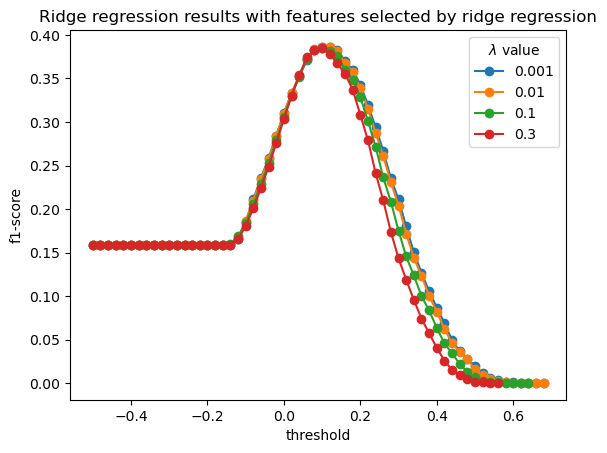

Ridge regression (selected by ridge regression):
Best f1-score: 0.386, best lambda: 0.001, best threshold: 0.120


In [ ]:
thr_l=np.arange(-0.5,0.7,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_tr_ridge,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_ridge,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results with features selected by ridge regression")
plt.show()

print(f'Ridge regression (features selected by ridge regression):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

### Logistic regression with features selected by ridge regression

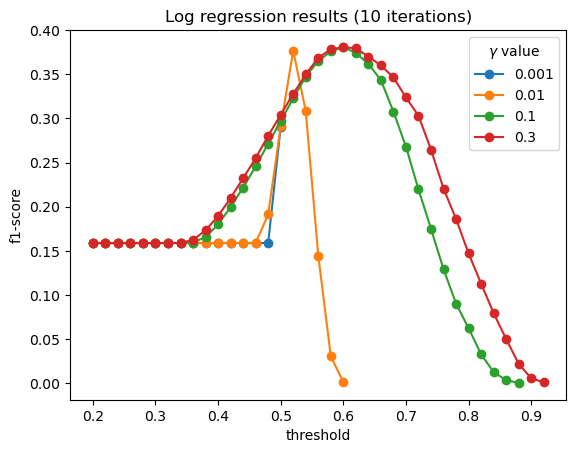

Log regression (selected by ridge regression):
Best f1-score: 0.381, best gamma: 0.1, best threshold: 0.600


In [ ]:
best_score = 0
best_threshold = 0
best_gamma = 0

thr_l=np.arange(0.2,1,0.02)
for gamma in [0.001,0.01,0.1,0.3]:
    w_opt, loss = logistic_regression(y_tr_clean,X_tr_ridge,initial_w=np.zeros(X_tr_ridge.shape[1]),max_iters=40,gamma=gamma)
    f1_scores=[compute_scores_logistic_regression(X_val_ridge,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_gamma = gamma
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.legend(title="$\\gamma$ value")
plt.title("Log regression results (10 iterations)")
plt.show()

print(f'Log regression (features selected by ridge regression):\nBest f1-score: {best_score:.3f}, best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

### Neural Network

the following cell takes about 15 minutes to run, it is not useful to run it !

In [ ]:
run_nn=False
if run_nn:
    input_size = X_train_scaled_aug.shape[1]
    hidden_size = int(X_train_scaled_aug.shape[1]*2/3)+1
    output_size = 1
    nn_model_scaled_aug = NeuralNetwork(input_size, hidden_size, output_size)

    nn_model_scaled_aug.train(X_train_scaled_aug, y_train_clean_aug.reshape(-1,1), epochs=1500,batching=True,batch_size=32)
    print(f"training f1-score : {nn_model_scaled_aug.compute_f1_score(X_train_scaled_aug,y_train_clean_aug.reshape(-1,1))}")
    print(f"validation f1-score:{nn_model_scaled_aug.compute_f1_score(X_validation_scaled,y_val_clean.reshape(-1,1))}")


Epoch 0, Loss: 1.3916
learning rate: 0.3
Epoch 0, F1 Score: 0.6218
Epoch 100, Loss: 1.1673
learning rate: 0.23213428124999994
Epoch 200, Loss: 0.8091
learning rate: 0.18907482291738273
Epoch 300, Loss: 0.6940
learning rate: 0.15400262498385145
Epoch 400, Loss: 0.6947
learning rate: 0.10754577672256257
Epoch 500, Loss: 0.5524
learning rate: 0.08321687193655013
Epoch 600, Loss: 0.7763
learning rate: 0.06439162918288119
Epoch 700, Loss: 0.5264
learning rate: 0.05244738441713911
Epoch 800, Loss: 0.5086
learning rate: 0.04058278628371678
Epoch 900, Loss: 0.5299
learning rate: 0.03140218641697651
Epoch 1000, Loss: 0.5697
learning rate: 0.02983207709612768
Epoch 1000, F1 Score: 0.6860
Epoch 1100, Loss: 0.5051
learning rate: 0.02308349258301395
Epoch 1200, Loss: 0.5046
learning rate: 0.021929317953863253
Epoch 1300, Loss: 0.5002
learning rate: 0.01979120945336158
Epoch 1400, Loss: 0.5376
learning rate: 0.016968488205075884


The scores we get by running the previous cell:

In [ ]:
print(f"training f1-score : {0.755050088}")
print(f"validation f1-score:{0.358245468}")

training f1-score : 0.755050088
validation f1-score:0.358245468


## Submission

In [ ]:
X_train_scaled, train_mean, train_std=scale_data(X_train,is_train_data=True)
X_validation_scaled, _, _=scale_data(X_validation,is_train_data=False,train_mean=train_mean,train_std=train_std)
X_test_scaled, _, _=scale_data(X_test,is_train_data=False,train_mean=train_mean,train_std=train_std)

X_train_scaled_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_scaled,y_tr_clean,ratio=0.5)

w_opt, loss = ridge_regression(y_train_clean_aug,X_train_scaled_aug,lambda_=0.01)

res_pred = make_predictions_linear_model(X_test_scaled, w_opt, threshold=0.460)

res_pred[res_pred == 0] = -1
create_csv_submission(test_ids, res_pred, 'submission_final.csv')